In [50]:
from math import ceil
import random
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

lst_densite = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
lst_prix = [1000, 1150, 1300, 1450, 1600, 1750, 1900, 2050, 2200, 2350, 2500]
lst_materiaux = ["détruit", "brique", "bois", "béton", "roche", "béton fibré"] #[20,30,50,150,250]
lst_resi = [0, 20, 30, 50, 150, 250]
lst_protection = ["détruit", "brise-lame", "digue", "mur"]




In [51]:
class Batiment:
    def __init__(self, resistance, hauteur, etat, coords):
        self.resi=resistance #1-10
        self.hauteur=hauteur #25-150
        self.etat=etat #100-0
        self.coords=coords #(i,j)
        self.mat=ceil(resistance/2) #1-5
        
    """def set_value_resi(self, valeur:int): #si besoin de set une value
        self.resi = valeur"""
        
    def __repr__(self):
        return "% s % s % s % s % s" % (self.resi, self.hauteur, self.etat, self.mat, self.coords)
    
    def detruit(self):
        self.resi=0
        self.hauteur=0
        self.etat=0
        self.mat=0
        
class Vague:
    def __init__(self, force, coords):
        #self.sens=sens #1,1.5,2,-1.5,-1,-0.5,0,0.5 == w, nw, n, ne, e, se, s, sw
        if force==-1:
            self.hauteur = 0.5
        elif force==0:
            self.hauteur = 1
        elif force==1:
            self.hauteur = 2
        elif force==2:
            self.hauteur = random.randint(4, 6)
        elif force==3:
            self.hauteur = random.randint(10, 20)
        elif force==4:
            self.hauteur = random.randint(20, 30)
        volume=100*self.hauteur #50m^2 car sur une case de 100m2 la vague != 100% de celle-ci
        m = 997 * volume
        pression_kg = m*10 #calcul trop compliqué donc estimation d'après la v et m^2 (/m^2)
        self.pression = round(pression_kg*0.00000981,2)
        self.force=force #(-1 à 4 sur l'échelle d'Imamura et Lida)
        self.coords=coords
        
    def __repr__(self):
        return "% s % s % s % s" % (self.force, self.hauteur, self.pression, self.coords)

class Civil:
    def __init__(self, nb_total, coords):
        self.nb_total = nb_total
        self.coords=coords
        
    def __repr__(self):
        return "% s % s" % (self.nb_total, self.coords)

class Protection:
    def __init__(self, types, niv_protection, coords):
        self.types = types #1-3 0=detruit
        self.niv_protection = niv_protection #1-5 0=detruit # sert à connaitre le matériau
        if types==0:
            self.hauteur = 0
        if types==1:
            self.hauteur = 2
        elif types==2:
            self.hauteur = niv_protection
        elif types==3:
            self.hauteur = niv_protection*3
        self.mat = niv_protection
        self.coords = coords
        
    def detruit(self):
        self.types=0
        self.niv_protection=0
        self.hauteur=0
        self.mat = 0
        
    def __repr__(self):
        return "% s % s % s % s % s" % (self.types, self.niv_protection, self.hauteur, self.mat, self.coords)

In [52]:
def show(matrice):
    for i in matrice:
        print(i)
    print(" ")
    
def show_mat(ville, coords):
    i, j = coords
    if isinstance(ville[i][j][0], Batiment):
        print(lst_materiaux[ville[i][j][0].mat])
        print(" ")
        return
    if isinstance(ville[i][j][0], Protection):
        print(lst_materiaux[ville[i][j][0].mat])
        print(" ")
        return
    else:
        print("Ce n'est pas un batiment !")
        print(" ")
        return
     

In [53]:
   
def crea_ville(taille):
        ville = [[0 for x in range(taille)] for y in range(taille)]
        return ville
    
def crea_batiment2(ville, taille):
    '''
    permet de setup la plage avec des valeurs à 0
    '''
    lst_bat = [(15,30),(30,45),(45,60),(60,75),(75,90),(90,105),(105,120),(120,135),(135,150),(300,400)]
    taille_ville = int((taille/3)*2)
    for i in range(taille):
        for j in range(taille_ville):
            bat_h = random.choices(lst_bat,[70,50,40,40,30,30,10,10,5,5])
            bat1, bat2 = bat_h[0]
            bat = [Batiment(random.randint(1, 10),random.randint(bat1, bat2),100,(i,j))]
            ville[i][j] = bat
        ville[i][taille_ville-1] = '_'
    return ville

def crea_batiment(ville, taille):
    '''
    permet de setup la plage avec des valeurs à 0
    '''
    taille_ville = int((taille/3)*2)
    for i in range(taille):
        for j in range(taille_ville):
            bat = [Batiment(random.randint(1, 10),random.randint(15,100),100,(i,j))]
            ville[i][j] = bat
        ville[i][taille_ville-1] = '_'
    return ville

def crea_vague(ville, force, taille):
    '''
    permet de créer le point d'origine du tsunami avec son sens et sa force
    '''
    for i in range(taille):
        for j in range(taille):
            if ville[i][j]==0:
                ville[i][j] = [Vague(force, (i,j))]
    return ville

def crea_protection(ville, taille, types, niv_protection):
    for i in range(taille):
        for j in range(taille):
            if ville[i][j]=='_':
                ville[i][j]=[Protection(types, niv_protection, (i,j))]
    return ville
    
def civilisation(ville, taille, densite):
    """ 
    permet d'attribuer les civils à la ville d'après une densité dans une échelle de 
    donnée par la liste lst_densite
    """
    mat_civil = crea_ville(taille)
    nb_civil_total = 0
    for i in range(taille):
        for j in range(taille):
            if isinstance(ville[i][j][0], Batiment):
                ht = ville[i][j][0].hauteur
                nb_civil = round(densite*ht)
                nb_civil_total = nb_civil_total + nb_civil 
                mat_civil[i][j] = [Civil(nb_civil, (i,j))]
            else:
                mat_civil[i][j] = [Civil(0, (i,j))]
    return mat_civil, nb_civil_total

def budget_ville(ville, taille, lst_prix): #eh merce hugo
    budget_ville=0
    for i in range(taille):
        for j in range(taille):
            if isinstance(ville[i][j][0],Batiment)==True:
                etage = int(ville[i][j][0].hauteur/3.3)
                budget_bat = lst_prix[ville[i][j][0].resi]*etage*100 #car surface==100m2 ?
                budget_ville+= budget_bat
            elif isinstance(ville[i][j][0], Protection)==True:
                budget_protection = lst_prix[ville[i][j][0].mat*2]*ville[i][j][0].hauteur*50
                budget_ville += budget_protection
                #faire deux budget différents ? 
    return budget_ville

def budget_protection(ville, taille, lst_prix):
    budget = 0
    for i in range(taille):
        for j in range(taille):
            if isinstance(ville[i][j][0],Protection)==True:
                budget_protection = lst_prix[ville[i][j][0].mat*2]*ville[i][j][0].hauteur*50
                budget += budget_protection
    return budget

In [54]:
def tsunami(ville, taille, mat_civil):
    h_v = 0
    p_v = 0
    nb_civil_total = 0
    for i in range(taille):
        for j in reversed(range(taille)):
            
            #print(h_v, p_v) #debuggage
            
            if isinstance(ville[i][j][0],Vague)==True: #mise a jour de la force et la hauteur de la vague
                h_v = ville[i][j][0].hauteur
                p_v = ville[i][j][0].pression
            
            if isinstance(ville[i][j][0], Batiment)==True: #calcul de la collision
                
                if ville[i][j][0].hauteur*1.1<h_v: #marge de 10%
                    ville[i][j][0].detruit()
                    mat_civil[i][j][0].nb_total = 0
                    h_v = h_v*0.9
                    p_v = p_v*0.9
                    
                elif ville[i][j][0].hauteur*1.1>=h_v:
                    #dépend donc des "stats" de celui-ci
                    
                    if p_v>lst_resi[ville[i][j][0].mat]:
                        temp = p_v - lst_resi[ville[i][j][0].mat] #si la vague est + puissante
                        pourcentage = (100*temp/p_v)
                        h_v = h_v - (h_v*pourcentage)/100
                        p_v = temp
                        ville[i][j][0].etat = int(ville[i][j][0].etat - (ville[i][j][0].etat*pourcentage)/100)
                        mat_civil[i][j][0].nb_total = int(mat_civil[i][j][0].nb_total-(pourcentage*mat_civil[i][j][0].nb_total)/100)
                        nb_civil_total += mat_civil[i][j][0].nb_total
                        
                    if p_v<lst_resi[ville[i][j][0].mat]:
                        temp = lst_resi[ville[i][j][0].mat] - p_v #si le mur résiste 
                        pourcentage = (100*temp)/lst_resi[ville[i][j][0].mat]
                        h_v = h_v - (h_v*pourcentage)/100
                        p_v = p_v - (pourcentage*p_v)/100
                        ville[i][j][0].etat = int(pourcentage)
                        mat_civil[i][j][0].nb_total = int((pourcentage*mat_civil[i][j][0].nb_total)/100)
                        nb_civil_total += mat_civil[i][j][0].nb_total
            
            if isinstance(ville[i][j][0], Protection)==True: #calcul collision avec les protections
                if ville[i][j][0].hauteur*1.1<h_v:
                    ville[i][j][0].detruit()
                elif ville[i][j][0].hauteur*1.1>h_v:
                    if p_v>lst_resi[ville[i][j][0].mat]:
                        temp = p_v - lst_resi[ville[i][j][0].niv_protection]
                        pourcentage = (100*temp/p_v)
                        h_v = h_v - (h_v*pourcentage)/100
                        p_v = temp
                    if p_v<lst_resi[ville[i][j][0].mat]:
                        temp = lst_resi[ville[i][j][0].niv_protection] - p_v #si le mur résiste 
                        pourcentage = (100*temp)/lst_resi[ville[i][j][0].niv_protection]
                        ville[i][j][0].niv_protection =  int(ville[i][j][0].niv_protection - (ville[i][j][0].niv_protection*pourcentage)/100)
                        h_v = (h_v*pourcentage)/100
                        p_v = (pourcentage*p_v)/100
    return ville, mat_civil, nb_civil_total

# Main

In [64]:
def main():
    #mise en place de la ville
    taille = int(input("Taille matrice de la ville: "))
    force = int(input("Force du tsunami (-1 à 4): "))
    ville = crea_ville(taille)
    ville = crea_batiment2(ville, taille)
    ville = crea_vague(ville, force, taille) 
    comp=0
    
    #mise en place civil & budget
    densite = int(input('Niveau de densité de population (0 à 9): '))
    mat_civil, nb_civil_total = civilisation(ville, taille, lst_densite[densite])
    budget = budget_ville(ville, taille, lst_prix)
    
    #premier show
    print(" ")
    print("Civils dans la ville:", nb_civil_total)
    show(mat_civil)
    print("Ville")
    show(ville)
    
    #début sim
    choix = input("Voulez-vous placer des protections ? (o/n) ")
    if choix=="o":
        #copies des var pour comparatif
        ville_p = deepcopy(ville)
        mat_civil_p = mat_civil
        nb_civil_total_p = nb_civil_total
        type_p = int(input("Quel type de protection (1/2/3): "))
        niv_p = int(input("Quel niveau de protection (1 à 5): "))
        print(" ")
        ville_p = crea_protection(ville_p, taille, type_p, niv_p)
        budget_p = budget_ville(ville_p, taille, lst_prix)
        budget_protect = budget_protection(ville_p, taille, lst_prix)
        print("Le budget pour cette ville est: ", budget_p, "€, dont", budget_protect, "€ pour les protections")
        show(ville_p)
        ville_p, mat_civil_p, new_nb_civil_total_p = tsunami(ville_p, taille, mat_civil_p)
    
    print(" ")
    ville_alt = deepcopy(ville)
    ville_alt, mat_civil, new_nb_civil_total = tsunami(ville_alt, taille, mat_civil)
    
    #résultats
    if choix=="o":
        print("Ville protégée par un(e)",lst_protection[type_p],"en",lst_materiaux[niv_p],"après un tsunami de force", force)
        show(ville_p)
        print("Civils restants dans la ville:", new_nb_civil_total_p, ", Nombre de pertes :", nb_civil_total_p-new_nb_civil_total_p)
        show(mat_civil_p)
        comp = input("Voulez-vous refaire cette simulation sans les protections ? (o/n) ")
    else:
        print("Le budget pour cette ville est: ", budget,"€")
        print(" ")
        print("Ville sans protection après un tsunami de force", force)
        show(ville_alt)
        print("Civils restants dans la ville:", new_nb_civil_total, ", Nombre de pertes :", nb_civil_total-new_nb_civil_total)
        show(mat_civil)
        
    if comp=="o":
        print(" ")
        print("Même ville sans protections après un tsunami de force", force)
        show(ville_alt)
        print("Civils restants dans la ville:", new_nb_civil_total, ", Nombre de pertes :", nb_civil_total-new_nb_civil_total)
        show(mat_civil)
        
    return

#budget_p = budget_protection(ville, taille, lst_prix)

In [65]:
main()

Taille matrice de la ville: 5
Force du tsunami (-1 à 4): 0
Niveau de densité de population (0 à 9): 5
 
Civils dans la ville: 2202
[[156 (0, 0)], [114 (0, 1)], [0 (0, 2)], [0 (0, 3)], [0 (0, 4)]]
[[132 (1, 0)], [342 (1, 1)], [0 (1, 2)], [0 (1, 3)], [0 (1, 4)]]
[[135 (2, 0)], [303 (2, 1)], [0 (2, 2)], [0 (2, 3)], [0 (2, 4)]]
[[210 (3, 0)], [441 (3, 1)], [0 (3, 2)], [0 (3, 3)], [0 (3, 4)]]
[[60 (4, 0)], [309 (4, 1)], [0 (4, 2)], [0 (4, 3)], [0 (4, 4)]]
 
Ville
[[9 52 100 5 (0, 0)], [3 38 100 2 (0, 1)], '_', [0 1 9.78 (0, 3)], [0 1 9.78 (0, 4)]]
[[8 44 100 4 (1, 0)], [3 114 100 2 (1, 1)], '_', [0 1 9.78 (1, 3)], [0 1 9.78 (1, 4)]]
[[10 45 100 5 (2, 0)], [6 101 100 3 (2, 1)], '_', [0 1 9.78 (2, 3)], [0 1 9.78 (2, 4)]]
[[8 70 100 4 (3, 0)], [9 147 100 5 (3, 1)], '_', [0 1 9.78 (3, 3)], [0 1 9.78 (3, 4)]]
[[9 20 100 5 (4, 0)], [5 103 100 3 (4, 1)], '_', [0 1 9.78 (4, 3)], [0 1 9.78 (4, 4)]]
 
Voulez-vous placer des protections ? (o/n) n
 
Le budget pour cette ville est:  43655000 €
 
Ville s

In [63]:
def main3():
    #mise en place de la ville
    taille = int(input("Taille matrice de la ville: "))
    force = int(input("Force du tsunami (-1 à 4): "))
    ville = crea_ville(taille)
    ville = crea_batiment2(ville, taille)
    ville = crea_vague(ville, force, taille) 
    comp=0
    
    #mise en place civil & budget
    densite = int(input('Niveau de densité de population (0 à 9): '))
    mat_civil, nb_civil_total = civilisation(ville, taille, lst_densite[densite])
    budget = budget_ville(ville, taille, lst_prix)
    
    #premier show
    print(" ")
    print("Civils dans la ville:", nb_civil_total)
    show(mat_civil)
    print("Ville")
    show(ville)
    
    #début sim
    choix = input("Voulez-vous placer des protections ? (o/n) ")
    if choix=="o":
        #copies des var pour comparatif
        ville_p = deepcopy(ville)
        mat_civil_p = mat_civil
        nb_civil_total_p = nb_civil_total
        type_p = int(input("Quel type de protection (1/2/3): "))
        niv_p = int(input("Quel niveau de protection (1 à 5): "))
        print(" ")
        ville_p = crea_protection(ville_p, taille, type_p, niv_p)
        budget_p = budget_ville(ville_p, taille, lst_prix)
        budget_protect = budget_protection(ville_p, taille, lst_prix)
        print("Le budget pour cette ville est: ", budget_p, "€, dont", budget_protect, "€ pour les protections")
        show(ville_p)
        ville_p, mat_civil_p, new_nb_civil_total_p = tsunami(ville_p, taille, mat_civil_p)
    
    print(" ")
    ville_alt = deepcopy(ville)
    ville_alt, mat_civil, new_nb_civil_total = tsunami(ville_alt, taille, mat_civil)
    
    #résultats
    if choix=="o":
        print("Ville protégée par un(e)",lst_protection[type_p],"en",lst_materiaux[niv_p],"après un tsunami de force", force)
        show(ville_p)
        print("Civils restants dans la ville:", new_nb_civil_total_p, ", Nombre de pertes :", nb_civil_total_p-new_nb_civil_total_p)
        show(mat_civil_p)
        comp = input("Voulez-vous refaire cette simulation sans les protections ? (o/n) ")
    else:
        print("Le budget pour cette ville est: ", budget,"€")
        print(" ")
        print("Ville sans protection après un tsunami de force", force)
        show(ville_alt)
        print("Civils restants dans la ville:", new_nb_civil_total, ", Nombre de pertes :", nb_civil_total-new_nb_civil_total)
        show(mat_civil)
        
    if comp=="o":
        print(" ")
        print("Même ville sans protections après un tsunami de force", force)
        show(ville_alt)
        print("Civils restants dans la ville:", new_nb_civil_total, ", Nombre de pertes :", nb_civil_total-new_nb_civil_total)
        show(mat_civil)
        
    return

#budget_p = budget_protection(ville, taille, lst_prix)

In [41]:
def main2(taille,force,densite,protec,type_p,niv_p):
    #mise en place des listes pour la suite
    new_nb_civil_total=0
    lst_densite = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    lst_prix = [1000, 1150, 1300, 1450, 1600, 1750, 1900, 2050, 2200, 2350, 2500]
    lst_materiaux = ["détruit", "brique", "bois", "béton", "roche", "béton fibré"] #[20,30,50,150,250]
    lst_resi = [0, 20, 30, 50, 150, 250]
    lst_protection = ["détruit", "brise-lames", "digue", "mur"]
    
    #mise en place de la ville
    ville = crea_ville(taille)
    ville = crea_batiment2(ville, taille)
    ville = crea_vague(ville, force, taille)  
    
    #mise en place civil & budget
    mat_civil, nb_civil_total = civilisation(ville, taille, lst_densite[densite])
    budget = budget_ville(ville, taille, lst_prix)
    
    #premier show
    #print(" ")
    #print("Emplacements des civils dans la ville:")
    #print("Civils dans la ville:", nb_civil_total)
    #show(mat_civil)
    #print("Le budget pour cette ville est: ", budget,"€")
    #show(ville)
    
    #début sim
    if protec=="o":
        #copies des var pour comparatif
        ville_p = ville
        mat_civil_p = mat_civil
        nb_civil_total_p = nb_civil_total
        #type_p = int(input("Quel type de protection (1/2/3): "))
        #niv_p = int(input("Quel niveau de protection (1 à 5): "))
        #print(" ")
        ville_p = crea_protection(ville_p, taille, type_p, niv_p)
        budget_p = budget_ville(ville_p, taille, lst_prix)
        budget_protect = budget_protection(ville_p, taille, lst_prix)
        #print("Le budget pour cette ville est: ", budget_p, "€, dont", budget_protect, "€ pour les protections")
        #show(ville_p)
        ville_p, mat_civil_p, new_nb_civil_total_p = tsunami(ville_p, taille, mat_civil_p)
        #print("Ville après tsunami: ")
        #print("Civils dans la ville:", new_nb_civil_total_p, ", Nombre de pertes :", nb_civil_total_p-new_nb_civil_total_p)
        #show(ville_p)
    else:
        #print(" ")
        ville, mat_civil, new_nb_civil_total = tsunami(ville, taille, mat_civil)
        #print("Civils restants dans la ville:", new_nb_civil_total, ", Nombre de pertes :", nb_civil_total-new_nb_civil_total)
        #show(mat_civil)
        #show(ville)
    return ville,mat_civil,nb_civil_total,nb_civil_total-new_nb_civil_total

matériau moyen de la ville:  2.1 (== brique )
hauteur moyenne de la ville:  52.8


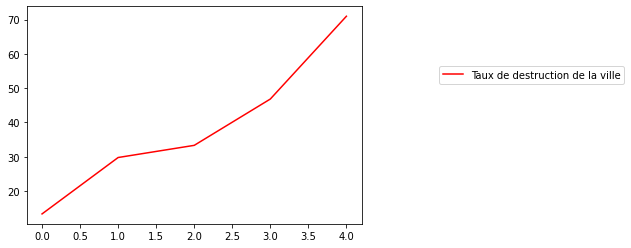

In [107]:
v1,mc1,nb_civil,nb_morts=main2(5,4,9,"n",3,5)

a=[]
taille_ville=5
nb_bats=0
def taux(ville,civil):
    taille_ville=len(ville)
    moy_etat=0
    nb_bats=0
    moy_hauteur=0
    moy_mat=0
    nb_civil_restant=0
    for i in range(taille_ville):
        for j in range(taille_ville):
            if isinstance(ville[i][j][0],Batiment):
                moy_etat+=ville[i][j][0].etat
                nb_bats+=1
                moy_hauteur+=ville[i][j][0].hauteur
                moy_mat+=ville[i][j][0].mat
                nb_civil_restant+=civil[i][j][0].nb_total
    taux_destruction=100-(moy_etat/nb_bats)
    
    moy_mat=moy_mat/nb_bats
    moy_hauteur=moy_hauteur/nb_bats
    pct_destruction=(100-(moy_etat)/nb_bats)/100
    #print("nombre de bâtiments: ",nb_bats)
    #print("Taux de déstruction moyen de la ville: ",100-(moy_etat/nb_bats),"%(",(100-(moy_etat/nb_bats))/100,")")
    return taux_destruction,pct_destruction,nb_bats,moy_mat,moy_hauteur,nb_civil_restant

taux(v1,mc1)

def find_mat(mat):
    mat=int(mat)
    if mat==1 or mat==2:
        return "brique"
    elif mat== 3 or mat==4:
        return "bois"
    elif mat== 5 or mat==6:
        return "beton"
    elif mat== 7 or mat==8:
        return "roche"
    elif mat== 9 or mat==10:
        return "béton fibré"

def analyse(nb_repet,ville,civil,taille,densite,mur,type_p,niv_p):
    final=[]
    for i in range(5):
        nb_bats_moy=[]
        destru_totale=[]
        pct_total=[]
        repet=np.arange(5)
        villedepart=ville
        for j in range(nb_repet):
            ville,civil,nb_civil,nb_perte=main2(taille,i,densite,mur,type_p,niv_p) #à mettre une fois
            #puis faire tsunami ici 
            destru,pct,nb_bats,mat,hauteur,nb_civil_restant=taux(ville,civil)
            nb_bats_moy.append(nb_bats)
            destru_totale.append(destru)
            pct_total.append(pct)            
        final.append(np.mean(destru_totale))
    #print("final: ",final)
    #print("Nombre de civil initial: ",nb_civil)
    #print("Nombre de morts: ",nb_perte)
    m=find_mat(mat)
    print("matériau moyen de la ville: ",mat, "(==",m,")")
    print("hauteur moyenne de la ville: ",hauteur)
    _= plt.plot(repet,final,color="red",label="Taux de destruction de la ville")
    plt.legend(bbox_to_anchor =(1.80, 0.75), ncol = 1)

analyse(100,v1,mc1,5,9,"o",3,5)

[0 1 2 3 4 5]
0
1
2
3
4


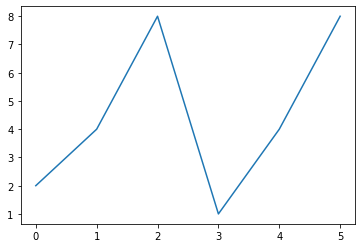

In [43]:
a=[2,4,8,1,4,8]
b=np.arange(6)
print(b)
plt.plot(b,a)
for i in range(5):
    print(i)

# Jeu de test

In [ ]:
#On set toutes les variables utiles pour les tests
lst_densite = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
lst_prix = [1000, 1150, 1300, 1450, 1600, 1750, 1900, 2050, 2200, 2350, 2500]
lst_materiaux = ["détruit", "brique", "bois", "béton", "roche", "béton fibré"] #[20,30,50,150,250]
lst_resi = [0, 20, 30, 50, 150, 250]
lst_protection = ["détruit", "brise-lames", "digue", "mur"]
taille = 5
force = 4

ville_test = crea_ville(taille)
ville_test = crea_batiment(ville_test,taille)
ville_test = crea_vague(ville_test, force, taille)

mat_civil, nb_civil_total = civilisation(ville_test, taille, lst_densite[0])
print("Civils dans la ville:", nb_civil_total)
show(mat_civil) #test matrice des civils

budget = budget_ville(ville_test, taille, lst_prix)
print("Le budget pour cette ville est: ", budget, "€") #test fn du budget (faite par Hugo)

ville_test = crea_protection(ville_test, taille, 1, 5)
budget2 = budget_ville(ville_test, taille, lst_prix)
print("Le budget pour cette ville+protection est: ", budget2, "€")

show(ville_test)
ville_test, mat_civil, new_nb_civil_total = tsunami(ville_test, taille, mat_civil)
print("Ville après tsunami")
print("Civils dans la ville:", new_nb_civil_total, ", Nombre de pertes :", nb_civil_total-new_nb_civil_total)
show(ville_test) #test des collisions du tsunami (fn coeur)